# Show/Prove that patent application counts in well defined markets are plateaued.

In [1]:
from ips_db_conn.s3_client import S3Client
from ips_db_conn.s3_url import S3Url

In [2]:
%run notebook_preamble.ipy

In [3]:
import ips_db_conn.pg2_client as pg2

def get_sector_application_counts_by_year(year):

    query = f"""
            select b.aon_sector_pk
                ,count(b.patent_pk) as _{year}_
            from sector_predictions.bestpatentsector b 
            left join ifi.patent p on p.patent_pk = b.patent_pk 
            left join entity.aonsectorsourcedata asd on asd.aon_sector_pk = b.aon_sector_pk 
            where asd.source_data_pk notnull
            and date_part('year', p.filing_dt) = {year}
            group by 1;
            """

    psg = pg2.PG2Client(source="file", dsn="IFI")
    df = psg.get_query(query)
    return df
    

In [4]:
import multiprocessing as mp
from contextlib import closing
from tqdm import tqdm
import numpy as np
import pandas as pd
from functools import reduce

years = np.linspace(2010, 2021, 12).astype(int)

cpu_count = mp.cpu_count()

with closing(mp.Pool(processes=cpu_count, maxtasksperchild=1)) as p:
    results = list(tqdm(p.map(get_sector_application_counts_by_year, years), total=len(years)))

df_merged = reduce(lambda  left, right: pd.merge(left,right,on=['aon_sector_pk'], how='inner'), results)

100%|██████████| 12/12 [00:00<00:00, 86778.70it/s]


# Collect sector application counts by year

In [5]:
df_merged.to_json("data/sector_application_counts_by_year.json")

In [6]:
df_merged = pd.read_json("data/sector_application_counts_by_year.json")

In [7]:
year_cols = list(df_merged.drop("aon_sector_pk", axis=1).columns)

# Some sectors have higher counts so we scale the rows (sector counts) using a min/max scaler so everything fits on one plot.

In [8]:
scaled_df = pd.DataFrame(columns=year_cols)
for i in range(df_merged.drop("aon_sector_pk", axis=1).shape[0]):
    x = df_merged.drop("aon_sector_pk", axis=1).loc[i, year_cols]
    scaled = (x - x.min())/(x.max() - x.min())
    scaled = pd.DataFrame(scaled).T
    scaled_df = pd.concat([scaled_df, scaled], ignore_index=True)
scaled_df

,_2010_,_2011_,_2012_,_2013_,_2014_,_2015_,_2016_,_2017_,_2018_,_2019_,_2020_,_2021_
0,0.628280,0.645773,0.774052,0.921283,0.880466,0.913994,0.915452,0.973761,1.000000,0.776968,0.520408,0.0
1,0.663150,0.734273,0.810266,0.901518,0.950128,1.000000,0.958481,0.908262,0.850640,0.677541,0.470049,0.0
2,0.665312,0.800361,0.882565,0.916441,0.906052,1.000000,0.981933,0.884372,0.877597,0.717706,0.454381,0.0
3,0.141689,0.207084,0.340599,0.433243,0.433243,0.392371,0.588556,0.822888,1.000000,0.705722,0.378747,0.0
4,0.506849,0.506849,0.424658,0.369863,0.808219,1.000000,0.520548,0.452055,0.438356,0.232877,0.150685,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.732068,0.767932,0.691983,0.831224,0.966245,1.000000,0.949367,0.848101,0.797468,0.632911,0.322785,0.0
1139,0.443299,0.536082,0.742268,0.716495,0.757732,0.819588,0.855670,1.000000,0.951031,0.819588,0.530928,0.0
1140,1.000000,0.754237,0.838983,0.953390,0.872881,0.576271,0.572034,0.601695,0.559322,0.622881,0.271186,0.0
1141,0.852941,0.813725,1.000000,0.970588,1.000000,0.990196,0.950980,0.960784,0.558824,0.686275,0.490196,0.0


# Let's look at the first 5 markets to see if we can make any inferences.

<AxesSubplot:>

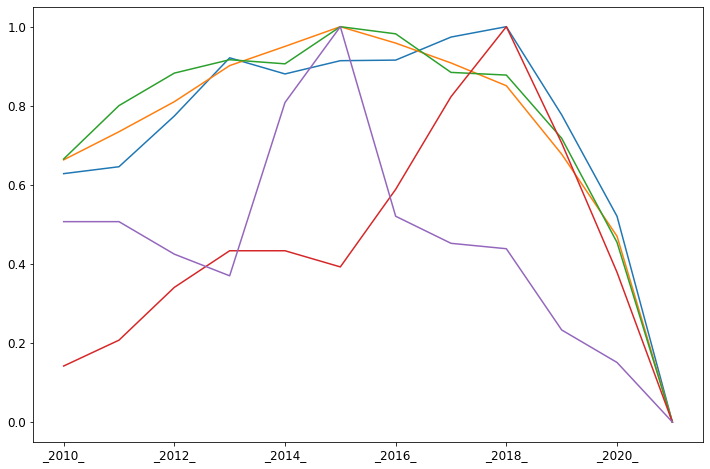

In [9]:
scaled_df[0:5].T.plot(legend=False, figsize=[12,8])

# There is a rise and fall so let's take a look at the cumulative sum of applications over time.

<AxesSubplot:title={'center':'Aggregate Sum of Patent Applications Over Time'}>

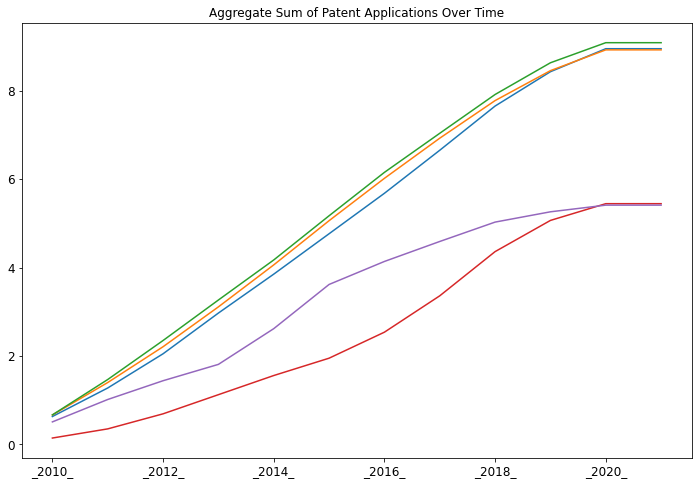

In [10]:
scaled_df.cumsum(axis=1)[0:5].T.plot(legend=False,
                                     figsize=[12,8],
                                     title="Aggregate Sum of Patent Applications Over Time")

# The sector application counts follow a typical life cycle S curve meaning there is very little change at the end of the cycle, from 2018 to 2020. We can take advantage of this by calculating the diff of the diff (or delta of the delta). A delta delta less than or equal to zero implies no significant change in application counts towards the end of the cycle.

In [11]:
delta_delta_scaled = scaled_df.cumsum(axis=1).diff(axis=1).diff(axis=1)

In [12]:
(delta_delta_scaled.loc[delta_delta_scaled['_2021_'] <= 0, '_2021_'].count()/delta_delta_scaled['_2021_'].count())*100

100.0

# It appears that 100% of the markets/sectors have no significant increase in application counts. But, 2021 is incomplete so let's set our cutoff to 2020.

In [13]:
(delta_delta_scaled.loc[delta_delta_scaled['_2020_'] <= 0, '_2020_'].count()/delta_delta_scaled['_2020_'].count())*100

95.10061242344707

# A more conservative estimate of 95% as of 2020. This doesn't mean that there will be no future growth, it simply means this is the data we have to work with.

# So, how do we find innovation if a majority of the markets are stagnate?

## Assuming markets/sectors are composed of smaller communities, perhaps we can find innovators through thematic segmentation (clustering).

In [14]:
import thematic_ip.src._sql_queries as sq
from similar_art_density.client import create_client
from sklearn.metrics.pairwise import pairwise_distances
import hdbscan

# Make sure results are reproduciable
np.random.seed(11)

# We need this to find similar patents
client = create_client()
client.load_index_files()


INFO: 2022-02-17 18:32:10,907: similar_art_density.logger: 17473: loading index


In [15]:
sector_data = sq.get_sector_patents(aon_sector_pk=1017)
patent_pks = sector_data['patent_pk']
sector_patents = sq.get_sector_data(patent_pks)
patent_ids = sector_patents['patent_id']

In [16]:
patent_vectors = {}
for seed_id in patent_ids:
    # Get the patent vectors from the client
    patent_vectors[seed_id] = client.get_vector(seed_id)
surviving_ids = list(patent_vectors.keys())
patent_cpc_vecs = patent_vectors.values()
patent_cpc_vecs = np.stack(patent_cpc_vecs)

# Pre-calculate the distance matrix to save time and money
distances = pairwise_distances(patent_cpc_vecs, metric="minkowski", n_jobs=-2)
logger.info(f"Fitting communities.")

clusterer = hdbscan.HDBSCAN(min_cluster_size=25,
                            min_samples=2,
                            metric="precomputed",
                            ).fit(distances)
        
n_communities = len(set(clusterer.labels_))
communities = pd.DataFrame(zip(surviving_ids, clusterer.labels_), columns=['patent_id','community'])
sector_patents = pd.merge(sector_patents, communities, on="patent_id")


INFO: 2022-02-17 18:33:20,564: __main__: 17473: Fitting communities.


<AxesSubplot:xlabel='year'>

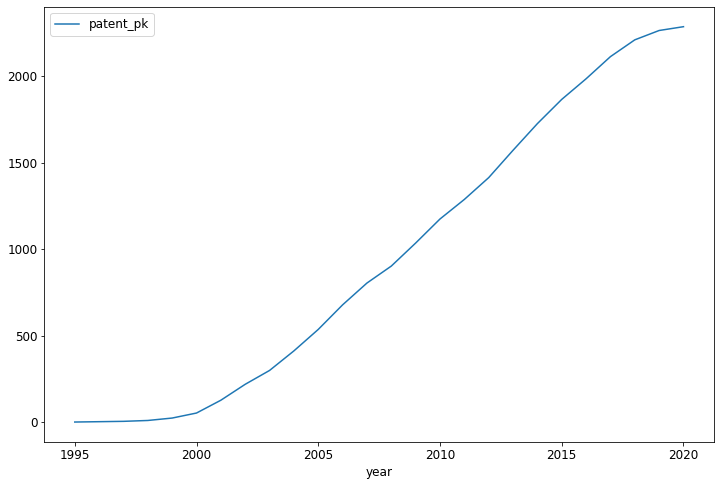

In [17]:
sector_patents['year'] = [i.year for i in sector_patents['filing_dt']]
grouped_df = sector_patents[sector_patents['year']>=1995].groupby(['year'])['patent_pk'].agg('count').to_frame()
grouped_df.cumsum().plot(figsize=[12,8])

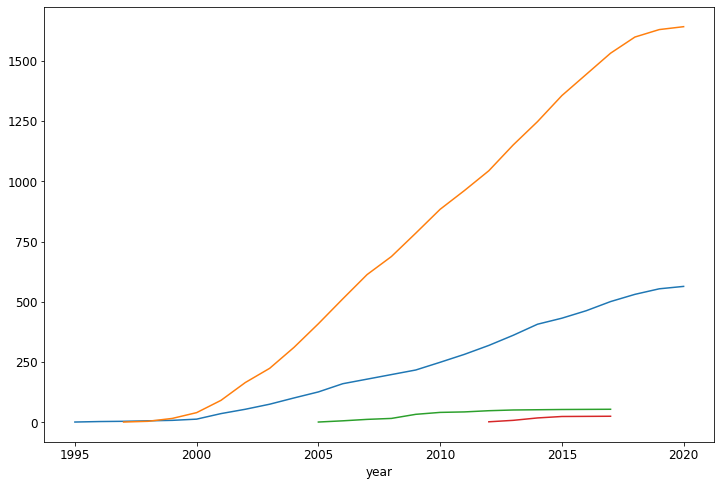

In [18]:
grouped_by_community = sector_patents[sector_patents['year']>=1995].groupby(['year','community'])['patent_pk'].agg('count').to_frame().reset_index()
for i in grouped_by_community['community'].unique():
    grouped_by_community[grouped_by_community['community']==i].set_index('year')['patent_pk'].cumsum().plot(figsize=[12,8])

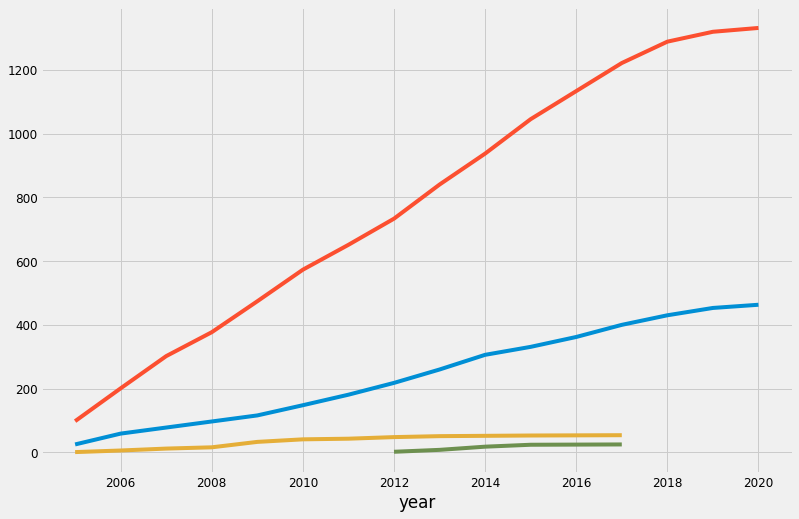

In [37]:
grouped_by_community = sector_patents[sector_patents['year']>=2005].groupby(['year','community'])['patent_pk'].agg('count').to_frame().reset_index()
for i in grouped_by_community['community'].unique():
    grouped_by_community[grouped_by_community['community']==i].set_index('year')['patent_pk'].cumsum().plot(figsize=[12,8])

# Therefore, we see there are pockets of communities that are still growing at a different pace than the larger market as a whole.

In [31]:
min_year = 1995

# get the counts of applicants
applicant_count = sector_patents[sector_patents['year'] > min_year].groupby(
    ['year'])["ifi_name"].nunique().to_frame()

# get the counts of applications
application_count = sector_patents[sector_patents['year'] > min_year].groupby(
    ['year'])["patent_id"].count().to_frame()

# create a new dataframe with counts per year
data = pd.merge(application_count,
                applicant_count,
                left_index=True,
                right_index=True,
                copy=False).reset_index()

data.columns = ['year', 'applications', 'applicants']

data = data.sort_values(by="year").reset_index(drop=True)
data['delta_applications'] = data['applications'].diff().fillna(0)

# Technology changes

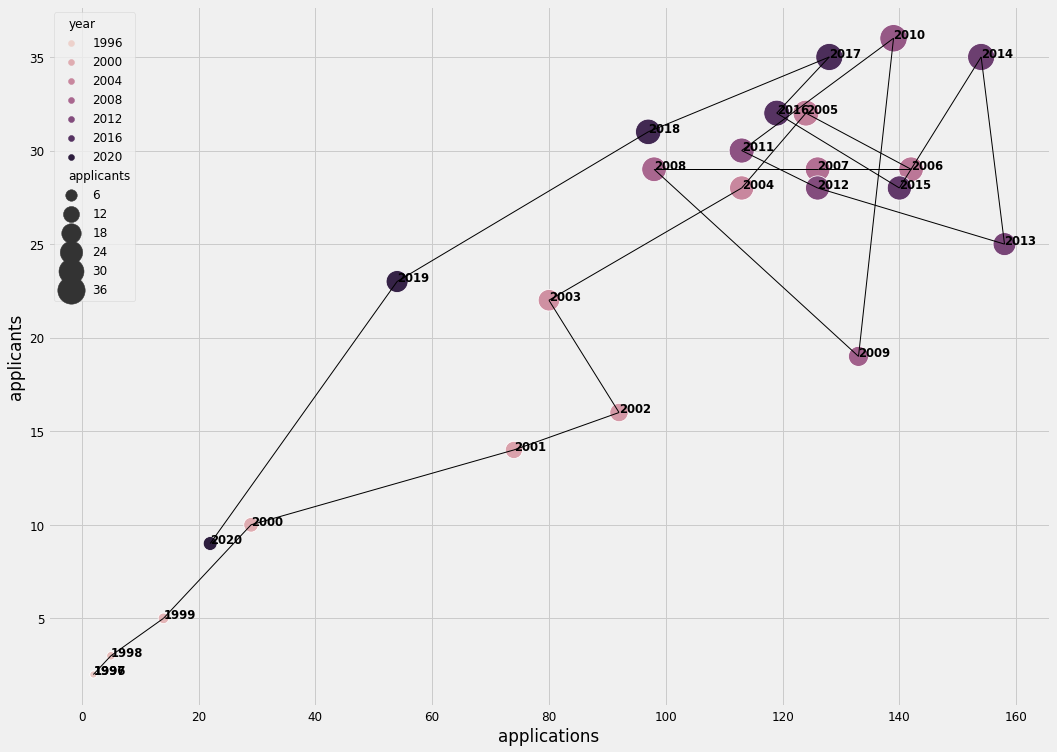

In [32]:
from precedence import prima_facie, pf_visualizations

pf_visualizations.create_timeline(data=data,
                    x="applications",
                    y="applicants",
                    size="applicants",
                    hue="year",
                    year_col="year",
                    highlight_seed_year=False,
                    savefig=False,
                    showplot=True
                   )

# Stages of maturity

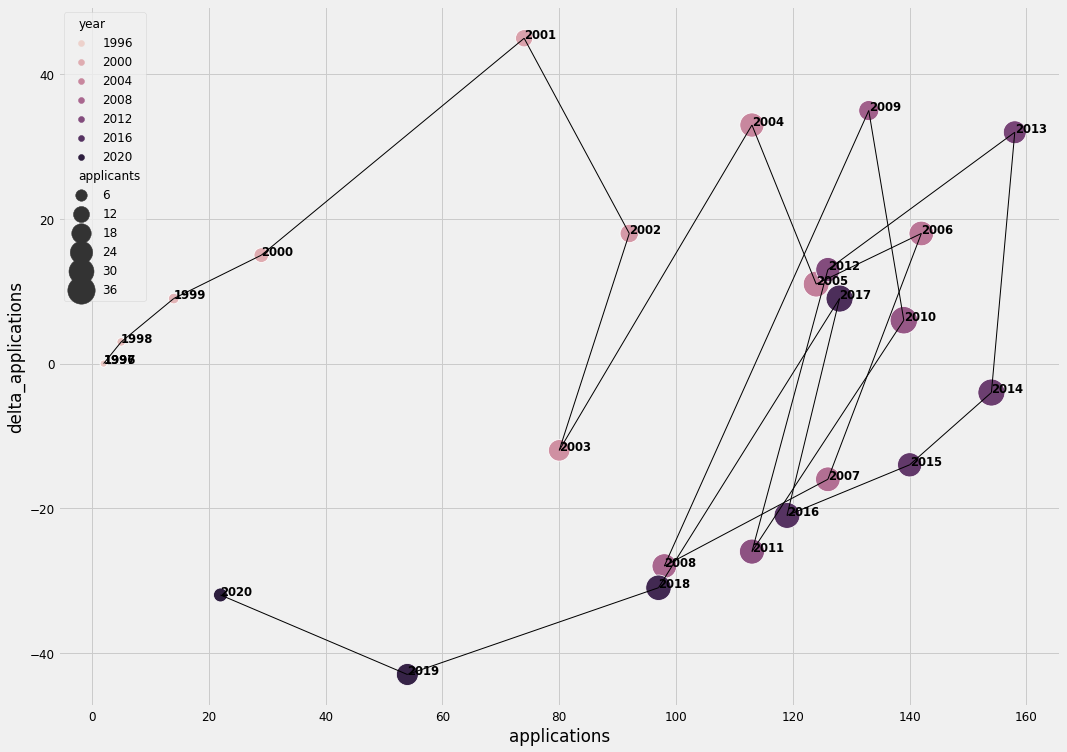

In [33]:
pf_visualizations.create_timeline(data=data,
                    x="applications",
                    y="delta_applications",
                    size="applicants",
                    hue="year",
                    year_col="year",
                    highlight_seed_year=False,
                    savefig=False,
                    showplot=True
                   )

# So, who are these masked troublemakers?

### What happens if we change applicants to communities?

In [42]:
min_year = 1995

# get the counts of applicants
applicant_count = sector_patents[sector_patents['year'] > min_year].groupby(
    ['year'])["community"].nunique().to_frame()

# get the counts of applications
application_count = sector_patents[sector_patents['year'] > min_year].groupby(
    ['year'])["patent_id"].count().to_frame()

# create a new dataframe with counts per year
c_data = pd.merge(application_count,
                applicant_count,
                left_index=True,
                right_index=True,
                copy=False).reset_index()

c_data.columns = ['year', 'applications', 'communities']

c_data = c_data.sort_values(by="year").reset_index(drop=True)
c_data['delta_applications'] = c_data['applications'].diff().fillna(0)


# Maturity cycle represented by communities

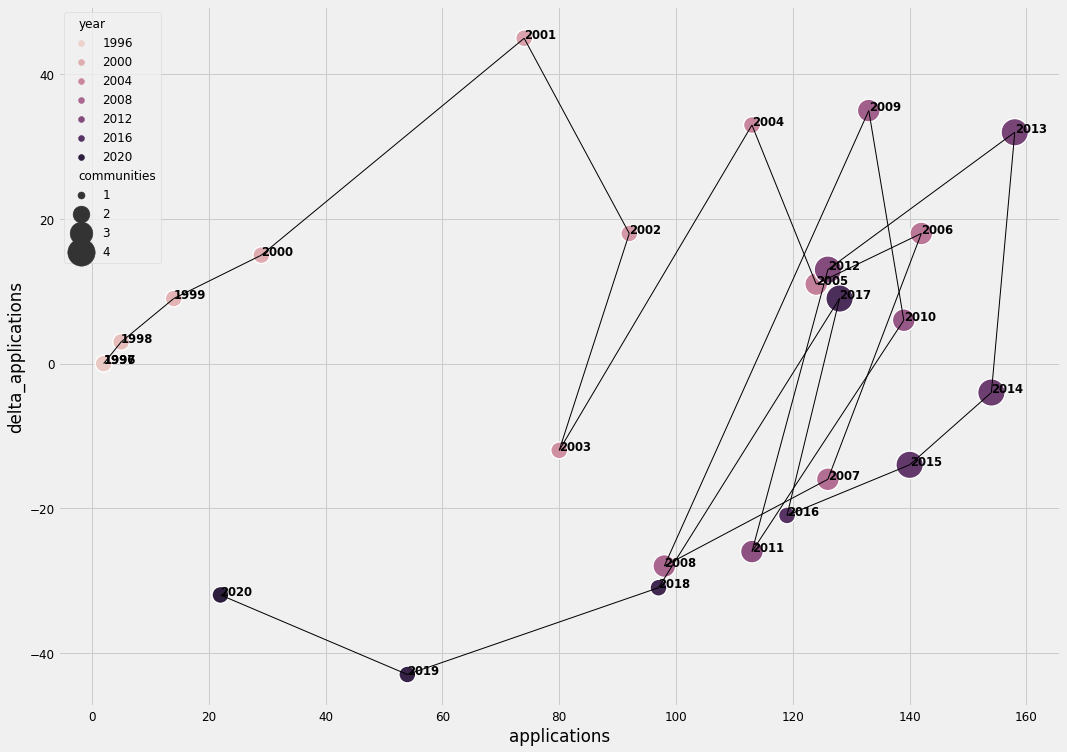

In [43]:
pf_visualizations.create_timeline(data=c_data,
                    x="applications",
                    y="delta_applications",
                    size="communities",
                    hue="year",
                    year_col="year",
                    highlight_seed_year=False,
                    savefig=False,
                    showplot=True
                   )

## We see that the size of the nodes are the same size inferring that the communities are doing a good job of representing the applicants.

# What about technology cycle?

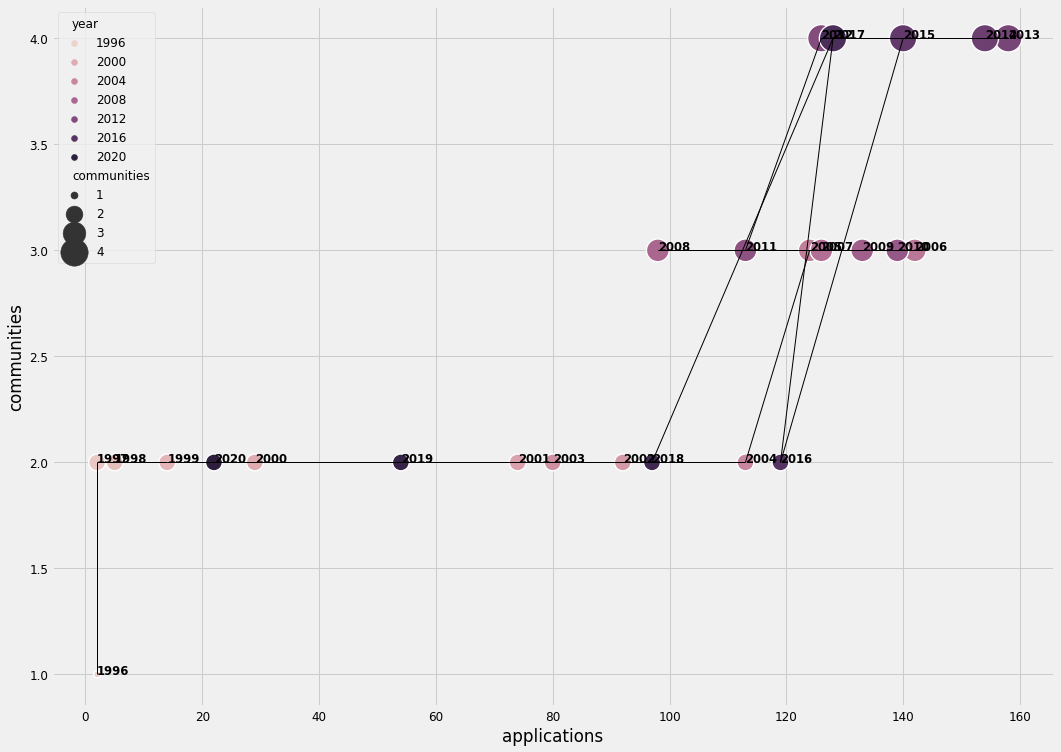

In [48]:
pf_visualizations.create_timeline(data=c_data,
                    x="applications",
                    y="communities",
                    size="communities",
                    hue="year",
                    year_col="year",
                    highlight_seed_year=False,
                    savefig=False,
                    showplot=True
                   )